# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Load The Data

In [1]:
# For later manipulation of the data
import numpy as np

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Basic Summary of the Data Set

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [162]:
import pandas as pd
import os
signnames = pd.read_csv("./signnames.csv")

signnames.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [167]:
signnames.iloc[i]["SignName"]

'Speed limit (20km/h)'

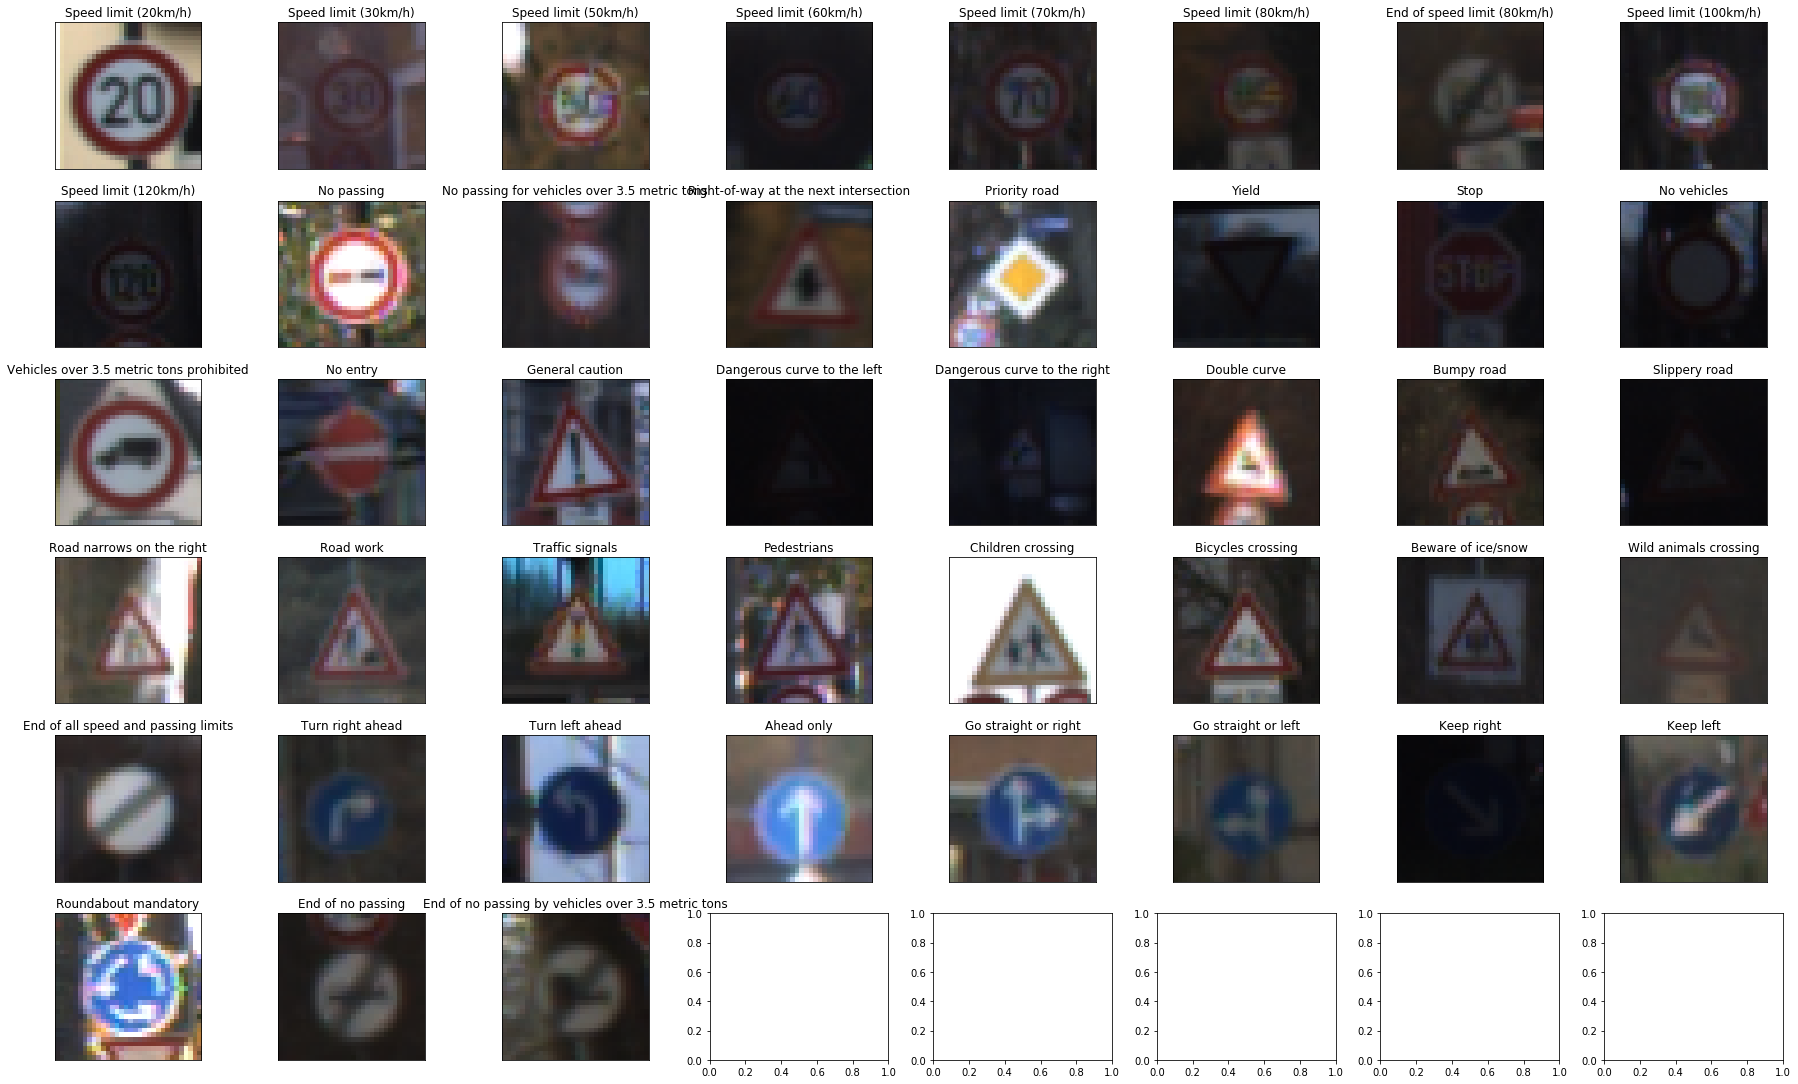

In [173]:
fig, axes = plt.subplots(6, 8, figsize=(25, 15))
fig.tight_layout()
axes = axes.ravel()

for i in np.unique(y_train):
    ix = np.where(y_train == i)[0][0]
    axes[i].imshow(X_train[ix])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(signnames.iloc[i]["SignName"])
    
fig.savefig("./sings.png")

## Preprocessing

In [6]:
import skimage
from skimage import exposure
import PIL

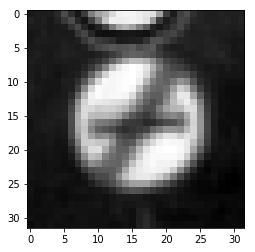

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Try out rgb --> gray
img = skimage.color.rgb2gray(X_train[10]) # Check conversion
plt.imshow(img, cmap="gray")

In [8]:
def reshape_3d(img):
    '''
    The neural network needs to have a 3rd dimension as well, this enforces it
    '''
    return img.reshape(img.shape[0], img.shape[1], 1)

def convert_to_gray(images):
    '''
    Function to convert a set of images into gray
    '''
    return np.array([reshape_3d(skimage.color.rgb2gray(img)) for img in images])

def center(img):
    mean =  np.mean(img)
    return (img-mean)/mean

def center_images(images):
    return np.array([center(img) for img in images])
    
# Function for normalization
# Based on this: https://www.researchgate.net/publication/281118372_NumPy_SciPy_Recipes_for_Image_Processing_Intensity_Normalization_and_Histogram_Equalization
def normalize_one(img):
    lmin = float(img.min())
    lmax = float(img.max())
    return np.floor((img-lmin)/(lmax-lmin)*255.).astype(np.uint8)

def normalize_all(images):
    return np.array([normalize_one(img) for img in images])
    
def equalize(images):
    return np.array([reshape_3d(exposure.equalize_adapthist(img.squeeze(), kernel_size=[15, 15])) for img in images])

In [9]:
X_train_gray = convert_to_gray(X_train)
X_test_gray  = convert_to_gray(X_test)
X_val_gray   = convert_to_gray(X_valid)

In [10]:
X_train_center = center_images(X_train_gray)
X_test_center  = center_images(X_test_gray)
X_val_center = center_images(X_val_gray)

In [11]:
# Normalization
X_train_norm = normalize_all(X_train_gray)
X_test_norm  = normalize_all(X_test_gray)
X_val_norm   = normalize_all(X_val_gray)

In [12]:
# Equalizaiton
X_train_equal = equalize(X_train_gray)
X_test_equal  = equalize(X_test_gray)
X_val_equal   = equalize(X_val_gray)

C:\Users\Zoltan\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


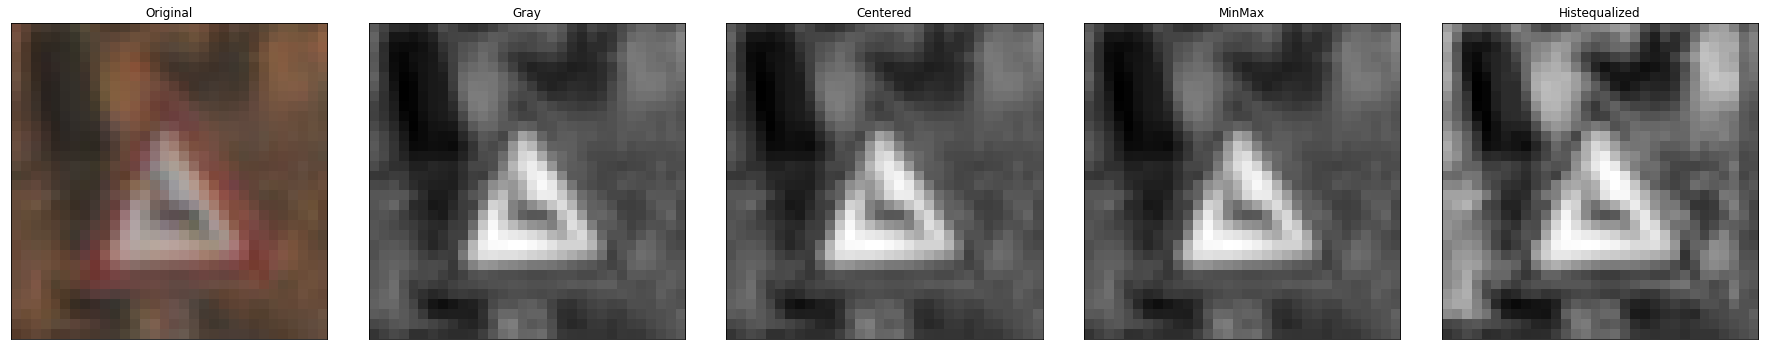

In [181]:
fig, axes = plt.subplots(1, 5, figsize=(25, 15))
fig.tight_layout()
axes = axes.ravel()
im_ix = 300

axes[0].imshow(X_train[im_ix])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original")

axes[1].imshow(X_train_gray[im_ix].squeeze(), cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Gray")

axes[2].imshow(X_train_center[im_ix].squeeze(), cmap="gray")
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("Centered")

axes[3].imshow(X_train_norm[im_ix].squeeze(), cmap="gray")
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title("MinMax")

axes[4].imshow(X_train_equal[im_ix].squeeze(), cmap="gray")
axes[4].set_xticks([])
axes[4].set_yticks([])
axes[4].set_title("Histequalized")

    
fig.savefig("pics/preprocess.png")

In [13]:
from sklearn.preprocessing import OneHotEncoder
oce = OneHotEncoder()
# We need one hot encoding, because we have multiple classes. 
y_train_oh = oce.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh  = oce.transform(y_test.reshape(-1, 1)).toarray()
y_val_oh   = oce.transform(y_valid.reshape(-1, 1)).toarray()

In [14]:
# We need shuffling
from sklearn.utils import shuffle
X_train_center_sh, y_train_center_sh = shuffle(X_train_center, y_train_oh, random_state=14)
X_train_gray_sh, y_train_gray_sh = shuffle(X_train_gray, y_train_oh, random_state=14)
X_train_norm_sh, y_train_norm_sh = shuffle(X_train_norm, y_train_oh, random_state=14)
X_train_equal_sh, y_train_equal_sh = shuffle(X_train_equal, y_train_oh, random_state=14)

### Model Architecture

In [15]:
import tensorflow as tf

In [16]:
tf.reset_default_graph()

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
X = tf.placeholder(tf.float32,shape=(None, 32, 32, 1))
y = tf.placeholder(tf.float32,shape=(None, n_classes))
mu = 0
sigma = 0.1
dropout_p = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)
weights = {
    #Input shape is 32*32*1 --> output shape is 28*28*6
    'w1_conv': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)),
    # Input: 28*28*16 --> 24*24*16
    'w2_conv': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
    # Maxpool --> 12*12*16
    # Input 12*12*16 --> 10*10*16
    'w3_conv': tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 16), mean = mu, stddev = sigma)),
    # Input 10*10*16 --> 10*10*16
    'w4_conv': tf.Variable(tf.truncated_normal(shape=(1, 1, 16, 16), mean = mu, stddev = sigma)),
    # Max pool
    # Dropout
    'w1_dense': tf.Variable(tf.truncated_normal(shape=(5*5*16, 256), mean = mu, stddev = sigma)),
    'w2_dense': tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma)),
    'w3_dense': tf.Variable(tf.truncated_normal(shape=(128, n_classes), mean = mu, stddev = sigma))
}
biases = {
        'b1_conv' : tf.random_normal([6]),
        'b2_conv' : tf.random_normal([16]),
        'b3_conv' : tf.random_normal([16]),
        'b4_conv' : tf.random_normal([16]),
        'b1_dense': tf.random_normal([256]),
        'b2_dense': tf.random_normal([128]),
        'b3_dense': tf.random_normal([n_classes])
}

In [18]:
# Based on this: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network_raw.py
def convolutional(data, W, b, stride=1, batch_norm=True):
    '''
    Wrapper around the conv2d function of Tensorflow
    '''
    output_conv = tf.nn.conv2d(data, W, strides=[1, stride, stride, 1], padding='VALID')
    output_bias = tf.nn.bias_add(output_conv, b) # Add bias
    if batch_norm:
        output_bias = tf.contrib.layers.batch_norm(output_bias, is_training=is_training)
    output_relu = tf.nn.relu(output_bias) # apply relu
    return output_relu

def pooling(data, k=2): # Default is 2x2 pooling
    return tf.nn.max_pool(data, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='VALID')

In [19]:
def model(input_data, weights, biases):
    conv1 = convolutional(input_data, weights['w1_conv'], biases['b1_conv'])
    #conv1 = pooling(conv1)
    conv2 = convolutional(conv1, weights['w2_conv'], biases['b2_conv'])
    conv2 = pooling(conv2)
    conv3 = convolutional(conv2, weights['w3_conv'], biases['b3_conv'])
    conv4 = convolutional(conv3, weights['w4_conv'], biases['b4_conv'])
    conv4 = pooling(conv4)
    flattened = tf.contrib.layers.flatten(conv4)
    d1 = tf.matmul(flattened, weights['w1_dense']) + biases['b1_dense']
    d1 = tf.nn.dropout(d1, dropout_p)
    d2 = tf.matmul(d1, weights['w2_dense']) + biases['b2_dense']
    d2 = tf.nn.dropout(d2, dropout_p)
    out = tf.matmul(d2, weights['w3_dense']) + biases['b3_dense']
    return out

In [20]:
import math
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    output_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        output_batches.append(batch)
        
    return output_batches

def print_epoch_stats(epoch_i, sess, last_features, last_labels):
    """
    Print cost and validation accuracy of an epoch
    """
    current_cost = sess.run(
        loss_op,
        feed_dict={X: last_features, y: last_labels, dropout_p: 0.8, is_training:False})
    train_acc = sess.run(
        accuracy,
        feed_dict={X: last_features, y: last_labels, dropout_p: 0.8, is_training:False}
    )
    valid_accuracy = sess.run(
        accuracy,
        feed_dict={X: X_val_equal, y: y_val_oh, dropout_p: 1.0, is_training:False})
    print('Epoch: {:<4} - Cost: {:<8.3} Train acc: {:<5.3} Valid Accuracy: {:<5.3}'.format(
        epoch_i,
        current_cost,
        train_acc,
        valid_accuracy))

In [21]:
train_batches = batches(256, X_train_equal_sh, y_train_equal_sh)
epochs = 150
lr = 0.0007

In [123]:
logits = model(X, weights, biases)
softmax_logits = tf.nn.softmax(logits)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss_op)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [124]:
saver = tf.train.Saver()

In [125]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch_i in range(epochs):
        for batch_features, batch_labels in train_batches:
            sess.run(train_op, feed_dict={X: batch_features, y: batch_labels, dropout_p: 0.8, is_training:False})
        if epoch_i % 10 == 0:
            print_epoch_stats(epoch_i, sess, batch_features, batch_labels)
            saver.save(sess, "./tmp/model.ckpt", global_step=epoch_i)
    print_epoch_stats(epoch_i, sess, batch_features, batch_labels)
    saver.save(sess, "./tmp/model.ckpt", global_step=epoch_i)

Epoch: 0    - Cost: 5.98     Train acc: 0.0167 Valid Accuracy: 0.0544
Epoch: 10   - Cost: 1.39     Train acc: 0.51  Valid Accuracy: 0.582
Epoch: 20   - Cost: 0.353    Train acc: 0.891 Valid Accuracy: 0.821
Epoch: 30   - Cost: 0.174    Train acc: 0.874 Valid Accuracy: 0.913
Epoch: 40   - Cost: 0.177    Train acc: 0.954 Valid Accuracy: 0.923
Epoch: 50   - Cost: 0.161    Train acc: 0.971 Valid Accuracy: 0.929
Epoch: 60   - Cost: 0.1      Train acc: 0.979 Valid Accuracy: 0.934
Epoch: 70   - Cost: 0.0377   Train acc: 0.975 Valid Accuracy: 0.943
Epoch: 80   - Cost: 0.0322   Train acc: 0.992 Valid Accuracy: 0.946
Epoch: 90   - Cost: 0.104    Train acc: 1.0   Valid Accuracy: 0.941
Epoch: 100  - Cost: 0.125    Train acc: 0.987 Valid Accuracy: 0.952
Epoch: 110  - Cost: 0.127    Train acc: 0.962 Valid Accuracy: 0.949
Epoch: 120  - Cost: 0.00167  Train acc: 0.996 Valid Accuracy: 0.947
Epoch: 130  - Cost: 0.0144   Train acc: 1.0   Valid Accuracy: 0.947
Epoch: 140  - Cost: 0.00313  Train acc: 0.992 

In [25]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [126]:
# On test set: load back the model:
with tf.Session() as sess:
    saver.restore(sess, "./tmp/model.ckpt-140")
    test_acc = sess.run(accuracy, feed_dict={X: X_test_equal, y: y_test_oh, dropout_p: 1.0, is_training:False})

INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt-140


In [127]:
test_acc 
# The model has a higher accuracy with a model used on earlier epochs, as later it overfits the training set.

0.93467933

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

C:\Users\Zoltan\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


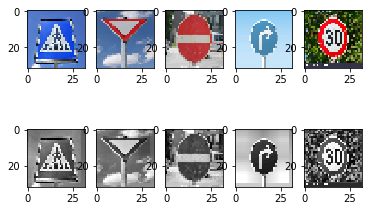

In [182]:
internet_images = []
fig, axes = plt.subplots(2, 5)

for ix, img in enumerate(os.listdir("./internet_pic/")):
    temp_image = PIL.Image.open("./internet_pic/" + img).resize([32, 32])
    internet_images.append(np.array(temp_image))

internet_images = np.array(internet_images)
internet_images_equal = equalize(convert_to_gray(np.array(internet_images)))
for ix, img in enumerate(internet_images):
    axes[0, ix].imshow(img)
    axes[1, ix].imshow(internet_images_equal[ix].squeeze(), cmap="gray")

In [131]:
y_internet = np.array([27, 13, 17, 33, 1])
y_internet_oh = oce.transform(y_internet.reshape(-1, 1)).toarray()

In [132]:
### Predict the Sign Type for Each Image

In [148]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, "./tmp/model.ckpt-120")
    internet_logits= sess.run(logits, feed_dict={X: internet_images_equal, y: y_internet_oh, dropout_p: 1.0, is_training:False})
    internet_acc = sess.run(accuracy, feed_dict={X: internet_images_equal, y: y_internet_oh, dropout_p: 1.0, is_training:False})


INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt-120


In [149]:
internet_acc # Unfortunateoy it doesnt really generalize well. Ie 30 is mistaken to be a 60khm sign

0.2

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [184]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, "./tmp/model.ckpt-120")
    sm_logits= sess.run(softmax_logits, feed_dict={X: internet_images_equal,
                                                          y: y_internet_oh, dropout_p: 1.0, is_training:False})
    top5 = sess.run(tf.nn.top_k(softmax_logits, 5), feed_dict={X: internet_images_equal,
                                                          y: y_internet_oh, dropout_p: 1.0, is_training:False})

INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt-120


In [185]:
top5

TopKV2(values=array([[  1.00000000e+00,   3.07822923e-09,   6.91732506e-14,
          4.89852595e-18,   9.00241133e-19],
       [  9.55220401e-01,   3.26126106e-02,   1.21463891e-02,
          1.66508635e-05,   2.08215693e-06],
       [  1.00000000e+00,   5.79886351e-26,   1.91961327e-35,
          0.00000000e+00,   0.00000000e+00],
       [  9.99998689e-01,   1.35855112e-06,   1.16043335e-10,
          1.49011047e-11,   9.48075559e-12],
       [  6.69939041e-01,   2.96203732e-01,   2.51909811e-02,
          5.23466989e-03,   3.29261064e-03]], dtype=float32), indices=array([[18, 26, 27, 25, 24],
       [18,  1, 24, 25,  6],
       [17, 14,  9,  0,  1],
       [35, 16, 11, 42, 34],
       [ 5,  7,  8,  3,  1]]))